# Topic modeling in humanitarian researches

## Loading libraries

In [58]:
import pandas as pd
import csv as cs
import re
import numpy as np
import time as tm
import os
import seaborn as sns
import matplotlib.pyplot as plt
from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.decomposition import NMF

## Loading the dataset

In [59]:
path = ''
dframe = pd.read_csv(os.path.join(path, "dataset.csv"))
print(dframe.head())

   id                                            content
0   0  Наиболее распространенной классификацией являе...
1   1  Сердцем Рима, средоточием его общественной жиз...
2   2  Книга была действенным средством распространен...
3   3  Глаголица - одна из двух древнейших славянских...
4   4  Торговля и хозяйственные дела способствовали р...


## Building the diagram of the distribution of texts by the number of characters

D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


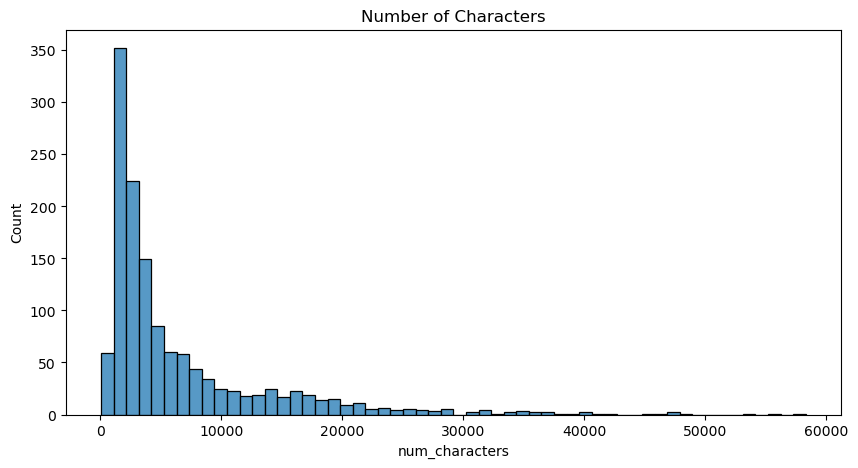

In [60]:
fig = plt.figure(figsize=(10, 5))
dframe["num_characters"] = dframe["content"].str.len()
sns.histplot(data=dframe, x="num_characters")
plt.title("Number of Characters")
plt.show()

## Cleaning the dataset

In [61]:
def datasetClean(dframe):
    dframe.content = dframe.content.apply(lambda x: re.sub("\\n", " ", x))
    dframe.content = dframe.content.apply(lambda x: " ".join(re.findall(r"[а-яА-Я ёЁ]+", x)))
    clean_text = []
    for text in dframe.content: 
        clean_text.append(text)  
    return clean_text
texts = datasetClean(dframe) 
print(f"The number of processed texts: {len(texts)}")

The number of processed texts: 1345


## Lemmatization of documents 

In [63]:
start_time = tm.time() 
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def natasha_lemmatize(text):
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  for token in doc.tokens:
    token.lemmatize(morph_vocab)
  return {_.text: _.lemma for _ in doc.tokens}
 
lemm_dict = []
lemmatize_texts = []
for text in texts: 
    lemm_dict.append(natasha_lemmatize(text))  
for x in lemm_dict: 
    sss = ''
    for xxx in list(x.values()):
        sss = sss + ' ' + xxx      
    lemmatize_texts.append(sss)
end_time = tm.time()
lemmatize_time = end_time - start_time
print(f"Execution time: {lemmatize_time:.2f}")

Execution time: 99.71


## Adding stop-words

In [64]:
stop_words = stopwords.words('russian')
stop_words.extend(['свой','весь','стать','новый','день','часть','час','век','конец','хороший','самый','против','год','это','однако']) 
stop_words.extend(['который','лишь','место','большой','человек','также','которые','время','очень','для','главный','тысяча','иметь','мочь']) 

## Filtering by selected grammatical categories

In [69]:
def grammaticalCategoriesFilter(categories_filter):
    grammatical_categories = []
    for lemm in lemmatize_texts:   
        words_set = ''
        doc = Doc(lemm)  
        doc.segment(segmenter)
        doc.tag_morph(morph_tagger)
        for token in doc.tokens:
            if ((token.pos in categories_filter) and (token.text not in stop_words)): 
                words_set = words_set + ' ' + token.text  
        grammatical_categories.append(words_set)      
    return grammatical_categories
    
start_time = tm.time()    
corpus = grammaticalCategoriesFilter(['NOUN','ADJ']) 
end_time = tm.time()
grammatical_time = end_time - start_time
print(f"Execution time: {grammatical_time:.2f}")

Execution time: 30.75


## LDA Topic Modeling

In [70]:
start_time = tm.time()
vectorizer = TfidfVectorizer(max_features=None) 
X = vectorizer.fit_transform(corpus)

num_topics = 15 
lda = LatentDirichletAllocation(n_components=num_topics, random_state=100)
lda.fit(X)

for topic_idx, topic_words in enumerate(lda.components_):
    top_words_idx = topic_words.argsort()[-9:][::-1]
    top_words = [vectorizer.get_feature_names_out()[i] for i in top_words_idx]
    # print(top_words)
    print(f"Тема {topic_idx + 1}: {', '.join(top_words)}")
end_time = tm.time()
LDA_time = end_time - start_time
print(f"Execution time: {LDA_time:.2f}")

Тема 1: здание, форма, город, стена, храм, сооружение, архитектура, архитектурный, архитектор
Тема 2: земский, азбука, огурец, глаголица, кириллица, кордовский, зарисовка, цифирный, струя
Тема 3: констриктор, балдахин, крыса, пьета, генрих, сундук, динценгофер, франциск, сиэтл
Тема 4: фарфор, фарфоровый, глазурь, обжиг, гончар, черепок, коричневый, кувшин, майолика
Тема 5: бриг, шив, фахверк, термы, вооружение, плотина, фрегат, микенский, строка
Тема 6: перфолента, ледяной, оператор, лицей, ленотр, пресс, гостиница, клавиатура, изник
Тема 7: сыр, салат, десерт, ложка, торт, помидор, равенна, вкусный, мороженое
Тема 8: франкский, связывание, трипольский, мебельный, шествие, тыква, парфянский, гостиница, фильм
Тема 9: грот, дивизион, специфический, отрицание, догмат, декарт, готский, поляна, орлов
Тема 10: гачный, петля, лапка, скопинский, интернат, кошачий, гак, рифовый, усмирение
Тема 11: хеттский, викторианский, беседочный, подъемник, огон, михаэль, спуск, баллиста, гнутье
Тема 12: ма

## NMF Topic Modeling

In [71]:
start_time = tm.time()
vectorizer = TfidfVectorizer(max_features=None) 
X = vectorizer.fit_transform(corpus)
num_topics = 15
nmf = NMF(n_components=num_topics, random_state=100)  
nmf.fit(X)
topic_names = vectorizer.get_feature_names_out()
for topic_idx, topic_words in enumerate(nmf.components_):
    top_words_idx = topic_words.argsort()[-9:][::-1]
    top_words = [topic_names[i] for i in top_words_idx]
    print(f"Тема {topic_idx + 1}: {', '.join(top_words)}") 
end_time = tm.time()
NMF_time = end_time - start_time
print(f"Execution time: {NMF_time:.2f}")

Тема 1: проект, архитектор, архитектурный, работа, здание, дом, творческий, архитектура, строительство
Тема 2: советский, немецкий, танковый, фронт, армия, войско, дивизия, оборона, удар
Тема 3: наука, природа, научный, философский, мир, философия, понятие, закон, идея
Тема 4: керамика, изделие, керамический, сосуд, глина, гончарный, фарфор, производство, глазурь
Тема 5: педагогический, школа, учебный, образование, заведение, обучение, ребенок, университет, русский
Тема 6: храм, древний, стена, римский, пирамида, город, церковь, памятник, сооружение
Тема 7: готический, собор, романский, художественный, свод, средневековый, готика, архитектурный, неф
Тема 8: войско, армия, война, отряд, сражение, поражение, бой, союзник, римский
Тема 9: почтовый, почта, письмо, гонец, доставка, марка, перевозка, услуга, корреспонденция
Тема 10: стул, спинка, сидение, кресло, мебель, ножка, форма, стиль, мебельный
Тема 11: мачта, парус, судно, парусный, стеньга, корабль, косой, прямой, бушприт
Тема 12: с